In [1]:
def seed_everything(seed):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


ValueError: zero-size array to reduction operation minimum which has no identity

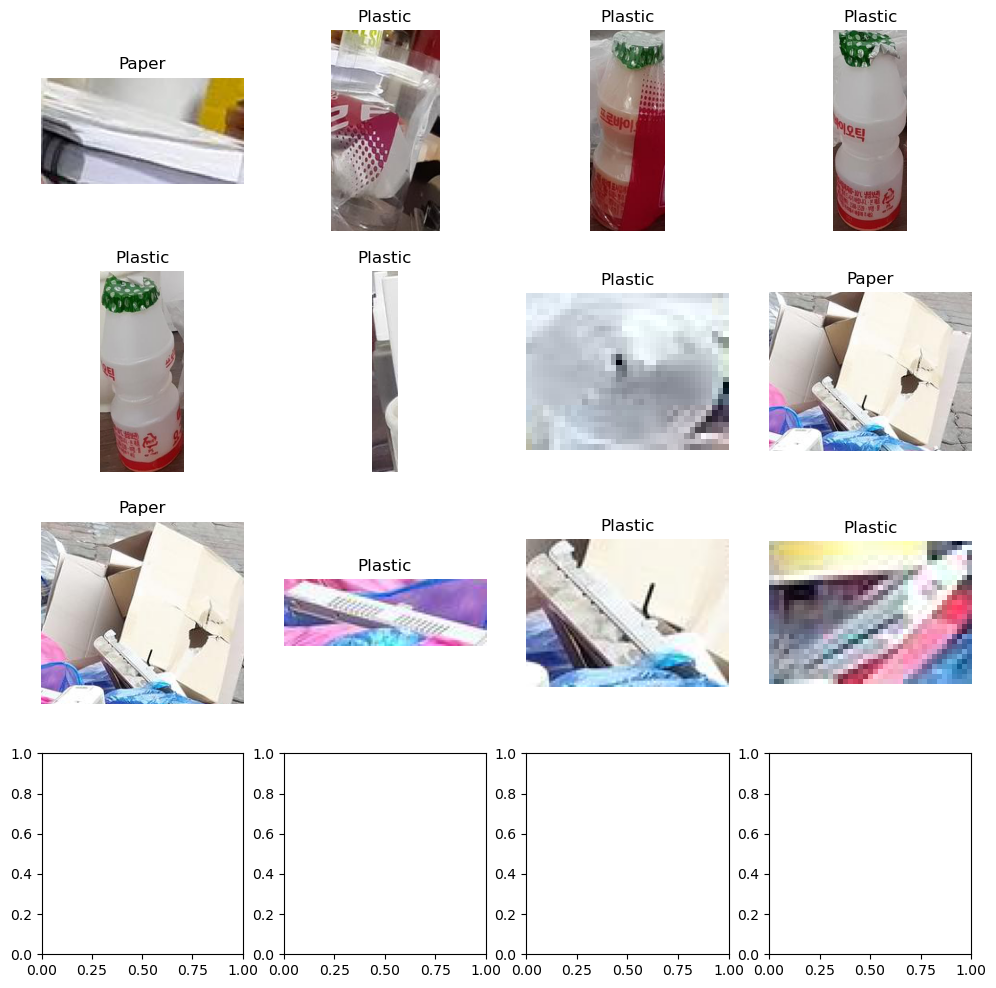

In [14]:
from pycocotools.coco import COCO
from PIL import Image
import os
import matplotlib.pyplot as plt

# COCO annotation 파일 경로
annotation = '/home/taeyoung4060ti/바탕화면/level2-objectdetection-cv-01/ultralytics-main/dataset/train.json'

# COCO API 불러오기
coco = COCO(annotation)

# 관심 있는 category_id 리스트
target_categories = [0, 1, 2, 5]

# 카테고리 id -> 이름 매핑
category_names = {cat['id']: cat['name'] for cat in coco.loadCats(target_categories)}

# 해당 category_id에 해당하는 모든 이미지 ID 가져오기
image_ids = set()
for cat_id in target_categories:
    image_ids.update(coco.getImgIds(catIds=[cat_id]))

# 필터링된 이미지 정보 불러오기
images = coco.loadImgs(list(image_ids))

# 이미지 경로 설정 (이미지 파일이 저장된 디렉토리 경로 설정 필요)
image_dir = '/home/taeyoung4060ti/바탕화면/level2-objectdetection-cv-01/ultralytics-main/dataset/'

# 결과를 저장할 디렉토리
output_dir = '/home/taeyoung4060ti/바탕화면/level2-objectdetection-cv-01/ultralytics-main/cropped_images_grid_with_labels/'
os.makedirs(output_dir, exist_ok=True)  # 결과 저장 폴더가 없으면 생성

# 이미지 그리드를 저장하는 함수
def save_image_grid(images, labels, output_path, grid_size=4):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axs = axs.ravel()  # 1차원 배열로 변환

    for i, ax in enumerate(axs):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(labels[i], fontsize=12)  # 각 이미지 위에 카테고리 이름 추가
            ax.axis('off')  # 축 숨김
        else:
            ax.axis('off')  # 빈 칸 처리

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # 이미지 간격 조정
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

# 이미지 처리 및 그리드로 저장
grid_size = 4  # 4x4 그리드
cropped_images = []
labels = []

for img in images:
    img_path = os.path.join(image_dir, img['file_name'])
    image = Image.open(img_path)

    # 이미지 ID로 해당하는 annotation을 가져옴
    ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=target_categories, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # 관심 있는 카테고리의 객체 바운딩 박스를 사용하여 이미지를 자르고 저장
    for ann in anns:
        bbox = ann['bbox']  # [x, y, width, height]
        x, y, w, h = bbox
        cropped_image = image.crop((x, y, x + w, y + h))

        # 카테고리 이름을 제목으로 추가
        category_name = category_names[ann['category_id']]
        
        cropped_images.append(cropped_image)
        labels.append(category_name)

        # 16개 모이면 그리드로 저장
        if len(cropped_images) == grid_size * grid_size:
            grid_output_name = f"{os.path.splitext(img['file_name'])[0]}_grid.jpg"
            grid_output_path = os.path.join(output_dir, grid_output_name)
            save_image_grid(cropped_images, labels, grid_output_path)
            cropped_images = []  # 리스트 초기화
            labels = []  # 라벨 리스트 초기화

# 마지막 남은 이미지가 있으면 그리드로 저장
if len(cropped_images) > 0:
    grid_output_name = "remaining_grid.jpg"
    grid_output_path = os.path.join(output_dir, grid_output_name)
    save_image_grid(cropped_images, labels, grid_output_path)

print("이미지 잘라서 그리드로 저장 완료!")